# Лабораторная работа №6

Выполнила Рындина Валерия, M33351

# Анализ картинок

In [1]:
import random
import numpy as np

import cv2

import torch
import torch.nn as nn

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange

# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10  # Количество классов

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Создайте эмбеддинги изображений и отобразите их в tensorboard projector'е

1. Скачайте датасет [CelebA](https://pytorch.org/vision/stable/datasets.html#celeba) или любой другой не рассмотренный на лекции

In [2]:
from torchvision.datasets import SVHN

basic_transform = transforms.Compose([
    transforms.ColorJitter(contrast=0.5, saturation=0.5),
    transforms.RandomInvert(),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.RandomGrayscale(p=1),
    transforms.ToTensor()
])

gray_transform = transforms.Compose([
    transforms.RandomGrayscale(p=1),
    transforms.ToTensor()
])

train_data = SVHN(
    root="data",
    split="train",
    download=True,
    transform=basic_transform
)

test_data = SVHN(
    root="data",
    split='test',
    download=True,
    transform=gray_transform
)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [3]:
dataloaders = {
    'train': DataLoader(
        dataset=train_data,
        batch_size=64,
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_data,
        batch_size=64,
        shuffle=False
    )
}

2. Выберите одну из предобученных [моделей torchvision](https://pytorch.org/vision/stable/models.html)

In [4]:
from torchvision.models import squeezenet1_1

class MyClassifier(nn.Module):
    def __init__(self, ouput_dim, embed_dims):
        super(MyClassifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = squeezenet1_1(pretrained=True, progress=True)  # Скачиваем пред-обученную основу для нашей модели

        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False

        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, embed_dims),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            # nn.Dropout(0.25),
            nn.Linear(embed_dims, ouput_dim),
            nn.ReLU()
        )

    def embed(self, x):
        return self.fc1(self.model(x))

    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [5]:
model = MyClassifier(OUTPUT_DIM, 64)
model.to(DEVICE)

MyClassifier(
  (model): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (exp

3. Создайте эмбеддинги изображений из датасета

In [6]:
train_items = [train_data[i] for i in range(1024)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(xs)
xs.size()

torch.Size([1024, 3, 32, 32])

In [7]:
embs = model.model(xs)
embs.size()

torch.Size([1024, 1000])

In [8]:
import umap

reducer = umap.UMAP(n_neighbors=20, min_dist=0.3, random_state=0, n_jobs=6)
points = reducer.fit_transform(embs.detach().numpy())

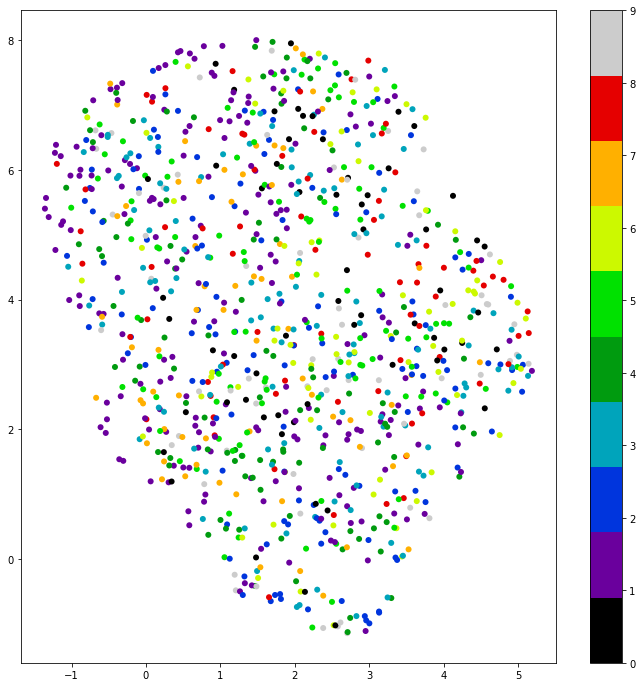

In [9]:
import matplotlib.pyplot as plt

def draw_clusters(x, y, cols):
    plt.figure(figsize=(12, 12))
    plt.scatter(x, y,
                c=cols, edgecolor='none',
                cmap=plt.cm.get_cmap('nipy_spectral', OUTPUT_DIM))
    plt.colorbar()
    plt.show()

draw_clusters(points[:, 0], points[:, 1], ys)

4. Визуализируйте эмбеддинги в tensorboard projector

In [10]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

In [11]:
# log embeddings
writer.add_embedding(embs,
                     metadata=ys,
                     label_img=xs)
writer.close()

https://projector.tensorflow.org/

# Лена

Примените фильтр к изображению Лены

1. Скачайте изображение [Лены](http://optipng.sourceforge.net/pngtech/img/lena.png)

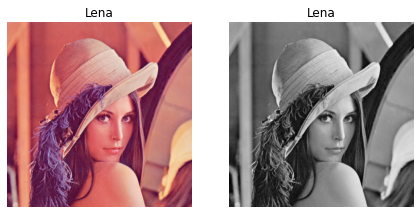

In [12]:
img_lena = cv2.imread('data/lena.png')  # Загрузка/чтение изображения
img = cv2.cvtColor(img_lena, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_lena, cv2.COLOR_BGR2GRAY)

def draw_lena(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n)
    for i, img_cyc in enumerate(images):
        ax[i].imshow(img_cyc, cmap='gray')
        ax[i].axis('off')
        ax[i].set_title('Lena')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()


draw_lena(img, img_gray)

2. Найдите фильтр для выделения признака на изображении. В лекции показан пример фильтра Собеля.

    Использовать примеры с лекций нельзя. Начать поиск фильтра можно с [этой страницы](https://en.wikipedia.org/wiki/Feature_(computer_vision)#Extraction)
    [Ridge detection](https://en.wikipedia.org/wiki/Ridge_detection)
3. Реализуйте процедуру свёртки изображения с фильтром

In [13]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

4. Сверните Лену

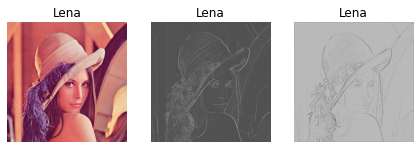

In [14]:
maxima_ridges, minima_ridges = detect_ridges(img_gray, sigma=0.5)
draw_lena(img, maxima_ridges, minima_ridges)
